# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install -q seaborn

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import os
import boto3
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt

s3 = boto3.client("s3")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
![ ! -f "dogImages.zip" ] && wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
!unzip -nq dogImages.zip

## Upload to S3

In [4]:
s3_bucket = "udacity-deeplearning-project"


# To skip if file already exist
s3 = boto3.client('s3')
paginator = s3.get_paginator('list_objects_v2')
operation_parameters = {
    'Bucket': s3_bucket,
    'Prefix': "data"
}

existing_jpgs = []
for page in paginator.paginate(**operation_parameters):

    for content in page.get('Contents', []):
        existing_jpgs.append(content['Key'])

existing_jpgs = [os.path.basename(x) for x in existing_jpgs if '.jpg' in x]

In [5]:
# Collect all files to upload
files_to_upload = []
for root, dirs, files in os.walk("dogImages"):
    for file in files:
        files_to_upload.append(os.path.join(root, file))

# Upload all images to s3 with progress bar
for file in tqdm(files_to_upload, desc="Uploading files to s3"):
    s3_prefix = f"data/{file}".replace("dogImages/", "")

    loading_jpg = os.path.basename(file)
    if loading_jpg in existing_jpgs: continue
    
    s3.upload_file(file, s3_bucket, s3_prefix)

Uploading files to s3: 100%|██████████| 8351/8351 [00:00<00:00, 19304.28it/s]


## Inspect Class Inbalance

In [6]:
image_list = []
for file_path in files_to_upload:
    split_file_path = file_path.split("/")
    label_numeric = split_file_path[-2].split('.')[0]
    processing_type = split_file_path[1]
    image_description = split_file_path[-2].split('.')[1]
    image_list.append([label_numeric, processing_type, image_description])

dog_breeds_df = pd.DataFrame(image_list, columns=["label_numeric", "processing_type", "dog_breed"])
dog_breeds_group_df = dog_breeds_df.groupby(["label_numeric", "processing_type", "dog_breed"], as_index=False).size().sort_values("size", ascending=False)

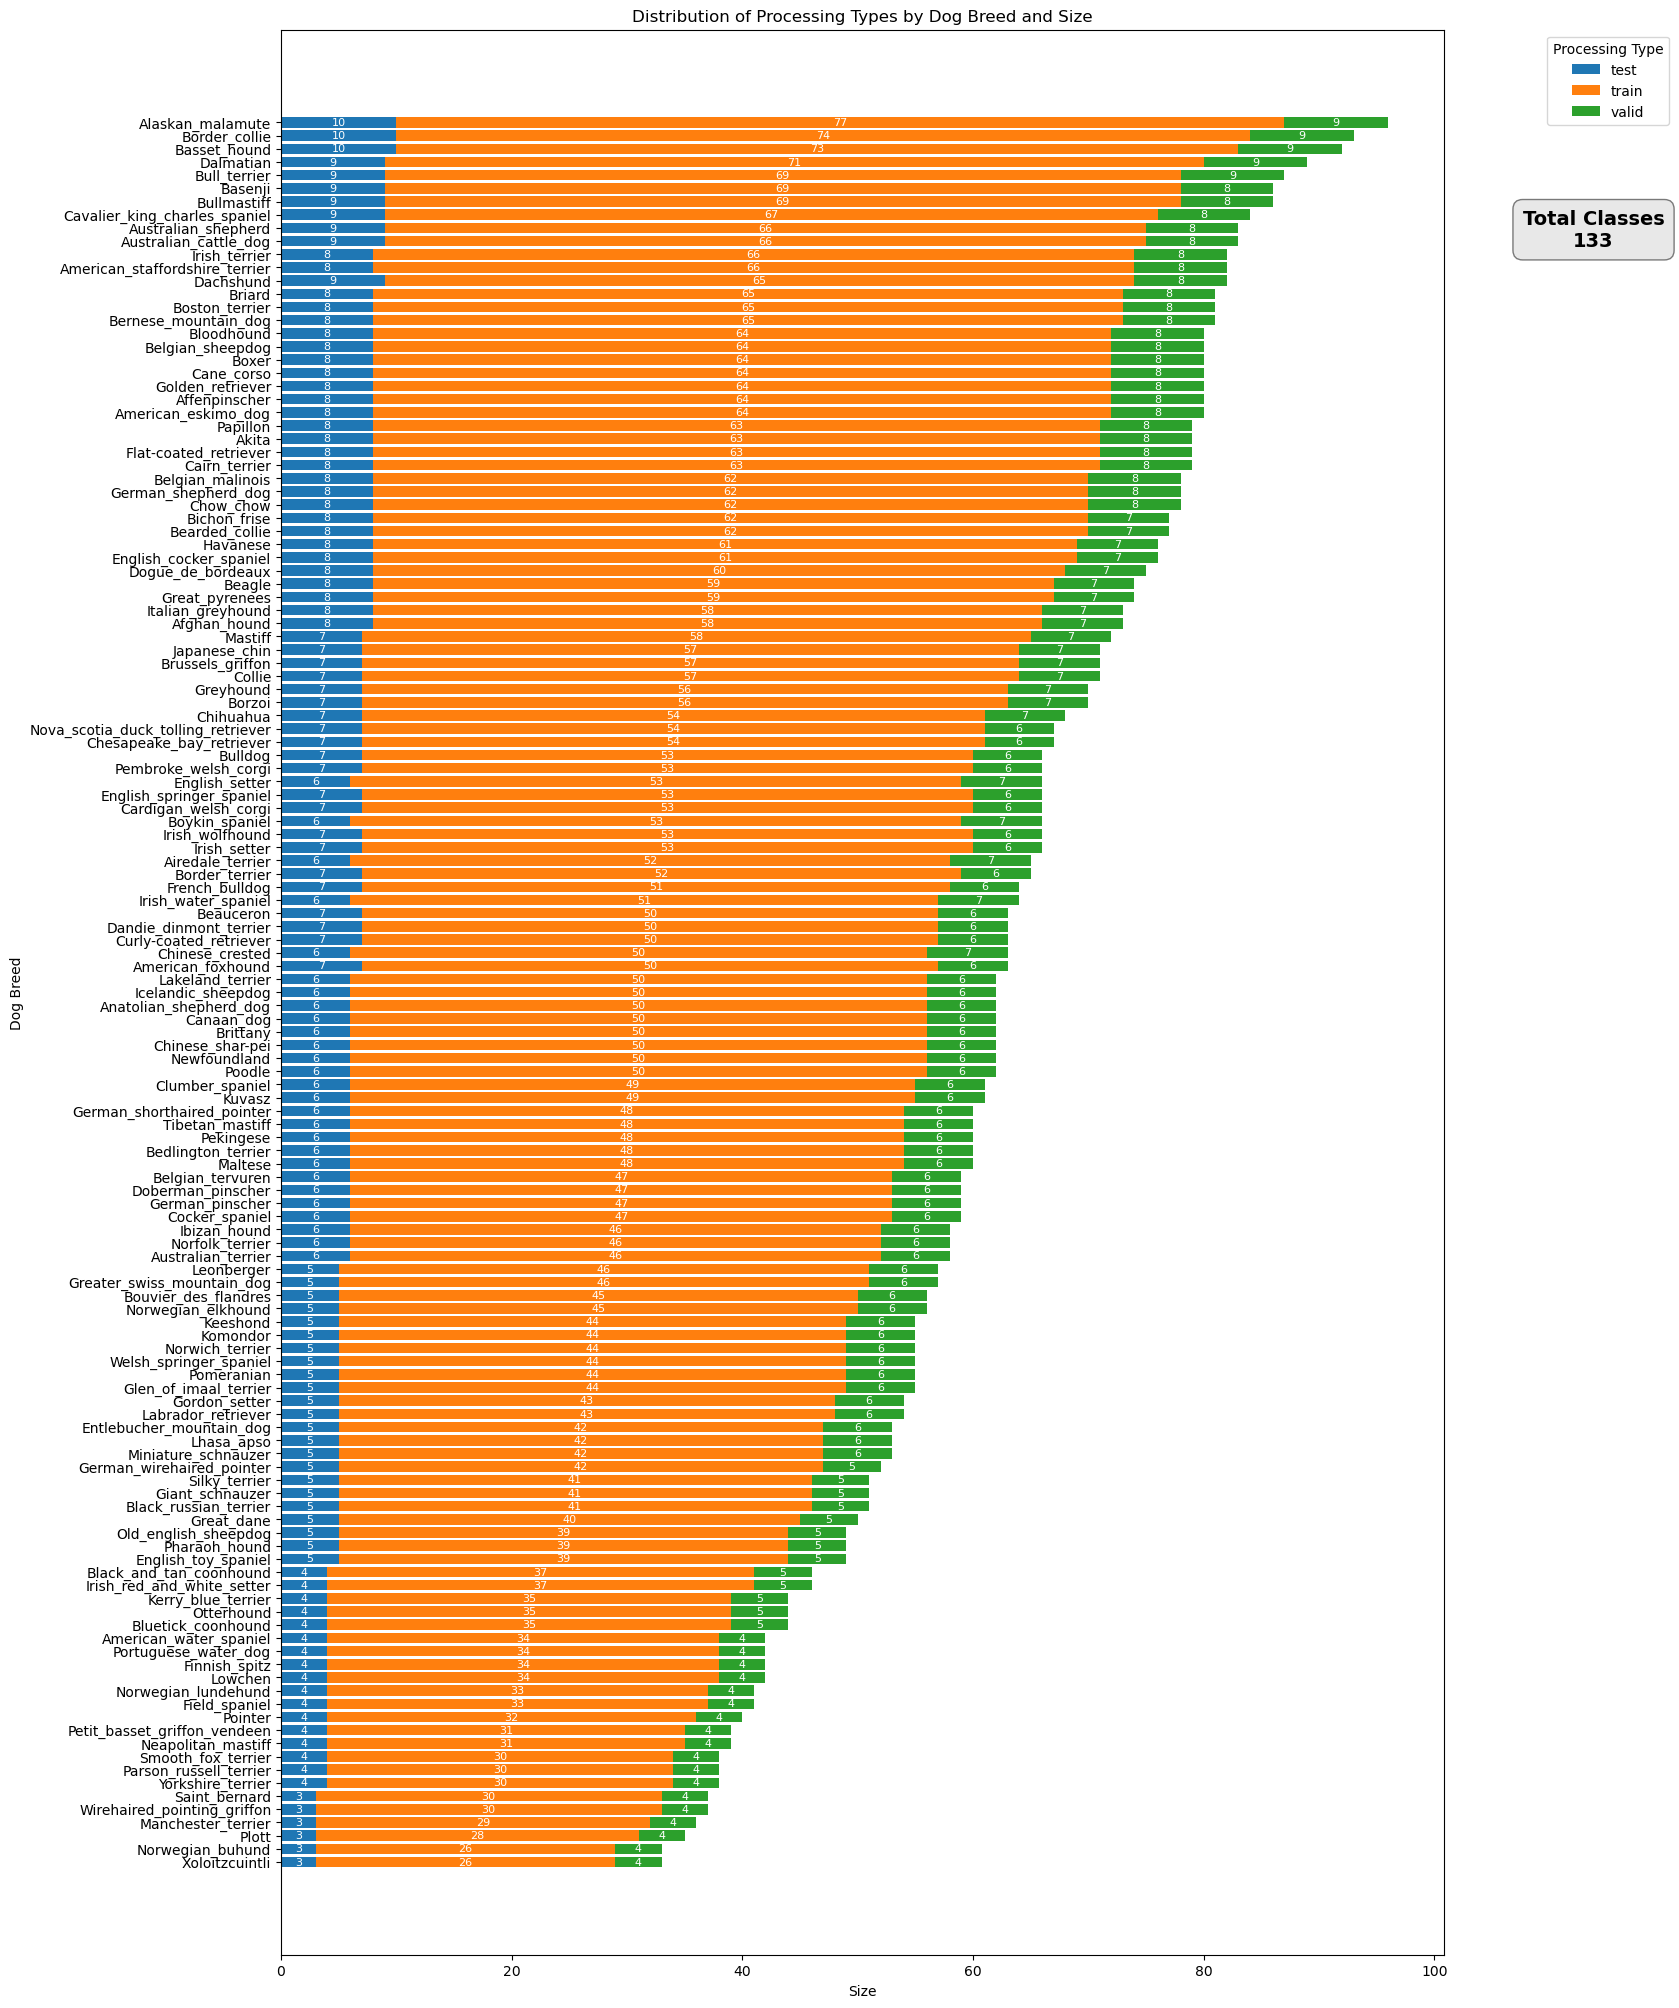

In [7]:
# Ignore all warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(15, 25))  # Increase the figure size for both plots

# Group and pivot the data for stacking
grouped_df = dog_breeds_group_df.groupby(["dog_breed", "processing_type"])["size"].sum().reset_index()
pivot_df = grouped_df.pivot(index="dog_breed", columns="processing_type", values="size").fillna(0)
pivot_df = pivot_df.assign(sorter=pivot_df.sum(axis=1)).sort_values("sorter", ascending=True).drop(columns=["sorter"])

# GRAPH ONE
# Calculate cumulative sums for stacking
bottoms = np.zeros(len(pivot_df))

# Plot each processing type as a separate bar
for processing_type in pivot_df.columns:
    ax.barh(pivot_df.index, pivot_df[processing_type], left=bottoms, label=processing_type)

     # Add annotations to each bar segment
    for i, value in enumerate(pivot_df[processing_type]):
        if value > 0:  # Only annotate if value is greater than 0
            ax.text(bottoms[i] + value / 2, i, str(int(value)), va='center', ha='center', fontsize=8, color='white')
        
    bottoms += pivot_df[processing_type]  # Update left position for next bar

# Customize the plot
ax.set_ylabel("Dog Breed")
ax.set_xlabel("Size")
ax.set_title("Distribution of Processing Types by Dog Breed and Size")
ax.legend(title="Processing Type", loc="upper right", bbox_to_anchor=(1.2, 1))


# GRAPH TWO
ax2 = fig.add_axes([0.85, 0.2, 0.1, 0.6])  # [left, bottom, width, height]
ax2.axis("off")  # Turn off the axis

# Display the total count as a card-like text
total_label_count = len(dog_breeds_group_df['label_numeric'].unique())
ax2.text(1.5, 1, f"Total Classes\n{total_label_count}", ha="center", va="center",
         fontsize=14, fontweight="bold", bbox=dict(facecolor="lightgray", alpha=0.5, boxstyle="round,pad=0.5"))

plt.show()

# Model Training & Tuning

## Hyperparameter Tuning - Completed
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [43]:
#DONE: Declare your HP ranges, metrics etc.
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter
import time

class DogBreedTuner:

    def __init__(self, model_type, instance_type):
        self.model_type = model_type
        self.instance_type = instance_type
    
    def start(self, wait=True):
    
        print(f"-> Running tuning job using {self.model_type}")
        
        hyperparameter_ranges = {
            "lr": ContinuousParameter(0.001, 0.1),
            "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
        }
        
        objective_metric_name = "average test loss"
        objective_type = "Minimize"
        metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]
        
        #DONE: Create estimators for your HPs
        from sagemaker.estimator import Estimator
        from sagemaker import get_execution_role
        
        role=get_execution_role()
        
        estimator=Estimator(
            image_uri='598308907998.dkr.ecr.us-east-1.amazonaws.com/udacity-sagemaker-hpo',
            role=role,
            py_version='py36',
            framework_version="1.8",
            instance_count=1,
            instance_type=self.instance_type,
            hyperparameters={
                "model-type": self.model_type
            }
        )
        
        tuner = HyperparameterTuner(
            estimator,
            objective_metric_name,
            hyperparameter_ranges,
            metric_definitions,
            max_jobs=1,
            max_parallel_jobs=1,
            objective_type=objective_type,
        )
        
        # DONE: Fit your HP Tuner
        bucket = 'udacity-deeplearning-project'
        sample_prefix = 'sample'
        
        model_inputs = model_inputs = {
            "train": sagemaker.inputs.TrainingInput(
                s3_data=f"s3://{bucket}/{sample_prefix}/data/train/",
                content_type="application/x-image"
            ),
            "test": sagemaker.inputs.TrainingInput(
                s3_data=f"s3://{bucket}/{sample_prefix}/data/test/",
                content_type="application/x-image"
            )
        }

        tuner.fit(inputs=model_inputs, wait=wait) # DONE: Remember to include your data channels

        self.tuner = tuner
        return "Success!"

    def get_best_estimator_job_name(self, max_retries=10, wait_time=60):
        """
        Waits for the tuner job to complete and retrieves the best estimator job name.
        
        Parameters:
            max_retries (int): Maximum number of retries before timing out.
            wait_time (int): Time in seconds to wait between retries.
    
        Returns:
            str: The best estimator job name if the tuning job completes successfully.
        """
        sagemaker_client = boto3.client("sagemaker")
        tuner_name = self.tuner.latest_tuning_job.name
        print(f"Checking status of tuner: {tuner_name}")
    
        # Retry logic
        for attempt in range(max_retries):
            response = sagemaker_client.describe_hyper_parameter_tuning_job(
                HyperParameterTuningJobName=tuner_name
            )
            tuner_status = response["HyperParameterTuningJobStatus"]
            
            if tuner_status == "Completed":
                print("Tuning job completed successfully."+" "*100)
                break
            elif tuner_status in ["Failed", "Stopped"]:
                raise RuntimeError(f"Tuning job {tuner_name} ended with status: {tuner_status}")
            else:
                print(f"Tuning job status: {tuner_status}. Attempt number {attempt+1}:{max_retries}. Retrying in {wait_time} seconds."+"."*attempt, end="\r", flush=True)
                time.sleep(wait_time)
        else:
            raise TimeoutError(f"Tuning job did not complete within {max_retries * wait_time} seconds.")
        
        # Retrieve the best estimator
        best_estimator = self.tuner.best_estimator()
        best_estimator_job_name = best_estimator.latest_training_job.name
    
        print(f"Best Estimator Job Name: {best_estimator_job_name}")
        return best_estimator_job_name


### - Tunning Multiple Models

In [44]:
resnet18 = DogBreedTuner("resnet18", 'ml.p3.2xlarge')
resnet18.start(wait=False)

print("-> Wait for a new date name for the next model...")
time.sleep(60)

mobilenetv2 = DogBreedTuner("mobilenetv2", 'ml.p2.xlarge')
mobilenetv2.start(wait=False)

-> Running tuning job using resnet18


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


-> Wait for a new date name for the next model...
-> Running tuning job using mobilenetv2


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


0

In [45]:
resnet18_best_job_name = resnet18.get_best_estimator_job_name()
mobilenetv2_best_job_name = mobilenetv2.get_best_estimator_job_name()

Checking status of tuner: udacity-sagemaker-hp-241127-1201
Tuning job completed successfully.empt number 2:10. Retrying in 60 seconds...

2024-11-27 12:04:54 Starting - Starting the training job
2024-11-27 12:04:54 Pending - Preparing the instances for training
2024-11-27 12:04:54 Downloading - Downloading the training image
2024-11-27 12:04:54 Training - Training image download completed. Training in progress.
2024-11-27 12:04:54 Uploading - Uploading generated training model
2024-11-27 12:04:54 Completed - Resource retained for reuse
Best Estimator Job Name: udacity-sagemaker-hp-241127-1201-001-9f413c52
Checking status of tuner: udacity-sagemaker-hp-241127-1202
Tuning job completed successfully.empt number 1:10. Retrying in 60 seconds...

2024-11-27 12:06:30 Starting - Preparing the instances for training
2024-11-27 12:06:30 Downloading - Downloading the training image
2024-11-27 12:06:30 Training - Training image download completed. Training in progress.
2024-11-27 12:06:30 Uploadin

## Model Profiling and Debugging - In Progress
> Create train_model.py and deploy container
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

**Note:** I included the profiler and debugger in the same `hpo.py` script and packaged it to ECR.

### - Retreiving Best Estimator Values
To be able to start the notebook from here after stoping resources

In [1]:
import boto3

def get_best_estimator_hyperparams(training_job_name):
    # Initialize the SageMaker client
    sagemaker_client = boto3.client("sagemaker")
    
    # Get the training job details
    response = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
    
    # Extract hyperparameters from the response
    hyperparameters = response.get("HyperParameters", {})
    hyperparameters.pop("_tuning_objective_metric")
    print(f"Best training hyperparameters: {hyperparameters}")

In [2]:
resnet18_best_job_hyperparams = get_best_estimator_hyperparams("udacity-sagemaker-hp-241127-1201-001-9f413c52")
mobilenetv2_best_job_hyperparams = get_best_estimator_hyperparams("udacity-sagemaker-hp-241127-1202-001-1001d69b")

Best training hyperparameters: {'batch-size': '64', 'lr': '0.0014736093036013917', 'model-type': 'resnet18'}
Best training hyperparameters: {'batch-size': '32', 'lr': '0.001680992255630517', 'model-type': 'mobilenetv2'}


### - Setting up Debugging and Profiler Rules and Config

In [3]:
# DONE: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### - Training Best Model Hyperparameters and Making Final Validation

In [6]:
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [10]:
!pip install bokeh==2.4.3

  Using cached bokeh-2.4.3-py3-none-any.whl.metadata (14 kB)
Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [11]:
!pip show bokeh smdebug

Name: bokeh
Version: 2.4.3
Summary: Interactive plots and applications in the browser from Python
Home-page: https://github.com/bokeh/bokeh
Author: Bokeh Team
Author-email: info@bokeh.org
License: BSD-3-Clause
Location: /opt/conda/lib/python3.11/site-packages
Requires: Jinja2, numpy, packaging, pillow, PyYAML, tornado, typing-extensions
Required-by: 
---
Name: smdebug
Version: 1.0.34
Summary: Amazon SageMaker Debugger is an offering from AWS which helps you automate the debugging of machine learning training jobs.
Home-page: https://github.com/awslabs/sagemaker-debugger
Author: AWS DeepLearning Team
Author-email: 
License: Apache License Version 2.0
Location: /opt/conda/lib/python3.11/site-packages
Requires: boto3, numpy, packaging, protobuf, pyinstrument
Required-by: 


In [12]:
# DONE: Create and fit an estimator
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
import IPython
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

role=get_execution_role()

class DogBreedTrainingProfiler:
    
    RULES = [
        Rule.sagemaker(rule_configs.loss_not_decreasing()),
        ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
        Rule.sagemaker(rule_configs.vanishing_gradient()),
        Rule.sagemaker(rule_configs.overfit()),
        Rule.sagemaker(rule_configs.overtraining()),
        Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ]
    
    PROFILER_CONFIG = ProfilerConfig(
        system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
    )
    DEBUGGER_CONFIG = DebuggerHookConfig(
        hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
    )

    def __init__(self, best_hyperparameters, instance_type):
        self.best_hyperparameters = best_hyperparameters
        self.instance_type = instance_type    
    
    def start(self):

        print(f"-> Starting the validation training using best trained hyperparameters {self.best_hyperparameters}...")
        
        estimator=Estimator(
            image_uri='598308907998.dkr.ecr.us-east-1.amazonaws.com/udacity-sagemaker-hpo',
            role=role,
            py_version='py36',
            framework_version="1.8",
            instance_count=1,
            instance_type=self.instance_type,
            hyperparameters=self.best_hyperparameters,
            profiler_config=self.PROFILER_CONFIG,
            debugger_hook_config=self.DEBUGGER_CONFIG,
            rules=self.RULES,
        )
        
        # DONE: Fit your HP Tuner
        bucket = 'udacity-deeplearning-project'
        sample_prefix = 'sample'
        
        model_inputs = model_inputs = {
            "train": sagemaker.inputs.TrainingInput(
                s3_data=f"s3://{bucket}/{sample_prefix}/data/train/",
                content_type="application/x-image"
            ),
            "test": sagemaker.inputs.TrainingInput(
                s3_data=f"s3://{bucket}/{sample_prefix}/data/valid/",
                content_type="application/x-image"
            )
        }

        # Wait always true due to having 10 max instance limit
        estimator.fit(inputs=model_inputs, wait=True) # DONE: Remember to include your data channels

        self.estimator = estimator

    def generate_profiler_report(self):
        session = boto3.session.Session()
        region = session.region_name
        
        training_job_name = self.estimator.latest_training_job.name
        print(f"Training jobname: {training_job_name}")
        print(f"Region: {region}")
        
        trial = create_trial(self.estimator.latest_job_debugger_artifacts_path())
        
        print(trial.tensor_names())
        print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
        print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))
        
        tj = TrainingJob(training_job_name, region)
        tj.wait_for_sys_profiling_data_to_be_available()
        
        system_metrics_reader = tj.get_systems_metrics_reader()
        system_metrics_reader.refresh_event_file_list()
        
        view_timeline_charts = TimelineCharts(
            system_metrics_reader,
            framework_metrics_reader=None,
            select_dimensions=["CPU", "GPU"],
            select_events=["total"],
        )
        
        rule_output_path = self.estimator.output_path + self.estimator.latest_training_job.job_name + "/rule-output"
        print(f"You will find the profiler report in {rule_output_path}")

    def display_profiler_report(self):
        # get the autogenerated folder name of profiler report
        profiler_report_name = [
            rule["RuleConfigurationName"]
            for rule in self.estimator.latest_training_job.rule_job_summary()
            if "Profiler" in rule["RuleConfigurationName"]
        ][0]
        
        display(IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html"))

[2024-11-28 20:17:27.366 default:125 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [14]:
# Waiting since there is a limit of 10 instances
resnet18_profile = DogBreedTrainingProfiler(resnet18_best_job_hyperparams, 'ml.p3.2xlarge')
resnet18_profile.start()

print("Waiting for all profiler and debugging processes to finish...")
time.sleep(60)

mobilenetv2_profile = DogBreedTrainingProfiler(mobilenetv2_best_job_hyperparams, 'ml.p2.xlarge')
mobilenetv2_profile.start()

-> Starting the validation training using best trained hyperparameters None...


INFO:sagemaker:Creating training-job with name: udacity-sagemaker-hpo-2024-11-28-20-17-47-087


2024-11-28 20:17:49 Starting - Starting the training job
2024-11-28 20:17:49 Pending - Training job waiting for capacity...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-11-28 20:18:40 Pending - Preparing the instances for training...
2024-11-28 20:19:20 Downloading - Downloading input data...
2024-11-28 20:19:40 Downloading - Downloading the training image......
2024-11-28 20:20:40 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
sed: can't read changehostname.c: No such file or directory
gcc: error: changehostname.c: No such file or directory
gcc: fatal error: no input files
compilation terminated.
gcc: error: changehostname.o: No such file or directory
ERROR: ld.so: object '/libchangehostname.so' 

INFO:sagemaker:Creating training-job with name: udacity-sagemaker-hpo-2024-11-28-20-22-06-077


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'Number of instances across all processing jobs' is 10 Instances, with current utilization of 7 Instances and a request delta of 7 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota.

### - Generate Profiler Report

In [16]:
resnet18_profile.generate_profiler_report()

Training jobname: udacity-sagemaker-hpo-2024-11-28-20-17-47-087
Region: us-east-1
[2024-11-28 20:30:15.086 default:125 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-598308907998/udacity-sagemaker-hpo-2024-11-28-20-17-47-087/debug-output
[2024-11-28 20:30:15.363 default:125 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-28 20:30:16.380 default:125 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.relu_input_1', 'relu_input_0']
1
1
ProfilerConfig:{'S3OutputPath': 's3

You will find the profiler report in s3://sagemaker-us-east-1-598308907998/udacity-sagemaker-hpo-2024-11-28-20-17-47-087/rule-output


In [17]:
mobilenetv2_profile.generate_profiler_report()

Training jobname: udacity-sagemaker-hpo-2024-11-28-20-25-21-075
Region: us-east-1
[2024-11-28 20:31:05.309 default:125 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-598308907998/udacity-sagemaker-hpo-2024-11-28-20-25-21-075/debug-output
[2024-11-28 20:31:05.586 default:125 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-28 20:31:06.610 default:125 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.relu_input_1', 'relu_input_0']
1
1
ProfilerConfig:{'S3OutputPath': 's3

You will find the profiler report in s3://sagemaker-us-east-1-598308907998/udacity-sagemaker-hpo-2024-11-28-20-25-21-075/rule-output


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [18]:
resnet18_profile.display_profiler_report()

In [20]:
mobilenetv2_profile.display_profiler_report()

# Model Registration

In [26]:
from sagemaker import Session
import tarfile
import os

class SageMakerModelRegistry:
    def __init__(self, model_package_group_name, training_job_name, local_inference_path):
        self.model_package_group_name = model_package_group_name
        self.training_job_name = training_job_name
        self.inference_path = local_inference_path

    def _repackage_with_inference(self, model_artifact, inference_path):
        s3 = boto3.client('s3')
        bucket_name, key = model_artifact.replace('s3://', '').split('/', 1)
        s3.download_file(bucket_name, key, '/tmp/model.tar.gz')
    
        # Extract the model artifact
        print("-> Extracting .tar.gz file...")
        with tarfile.open('/tmp/model.tar.gz', 'r:gz') as tar:
            tar.extractall('/tmp/model')
    
        # Copy the inference code to the model directory
        os.makedirs('/tmp/model/code', exist_ok=True)
        inference_path = os.path.join(inference_path, "*")
        os.system(f"cp {inference_path} /tmp/model/code/")
    
        # Repackage the model artifact
        print("-> Repackaging inference in new tar.gz file...")
        with tarfile.open('/tmp/model.tar.gz', 'w:gz') as tar:
            tar.add('/tmp/model', arcname='.')
    
        # Upload the re-packaged model artifact
        print("-> Replacing original tar.gz file...")
        s3.upload_file('/tmp/model.tar.gz', bucket_name, key) 

    def register(self):

        # Initialize SageMaker session and client
        sagemaker_session = Session()
        sagemaker_client = boto3.client("sagemaker")
        
        # Retrieve the model artifact from the training job
        print("-> Retreiving model artifact...")
        training_job_name = self.training_job_name
        response = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
        model_artifact = response["ModelArtifacts"]["S3ModelArtifacts"]
        print(f"Model artifact: {model_artifact}")
        
        print("Repackaging model artifact...")
        self._repackage_with_inference(model_artifact, inference_path=self.inference_path)

        
        # Define a model package group name (used for grouping related models)
        model_package_group_name = self.model_package_group_name
        
        # Ensure the model package group exists, or create it if it doesn't
        try:
            sagemaker_client.create_model_package_group(
                ModelPackageGroupName=model_package_group_name,
                ModelPackageGroupDescription="Group for Dog Breed Classifier models",
            )
            print(f"Model Package Group '{model_package_group_name}' created.")
        except sagemaker_client.exceptions.ClientError as e:
            if "Model Package Group already exists" in str(e):
                print(f"Model Package Group '{model_package_group_name}' already exists. Adding a new version.")
            else:
                raise  # Reraise if it's another exception
        
        # Register the model in the model package group as a new version
        model_package_response = sagemaker_client.create_model_package(
            ModelPackageGroupName=model_package_group_name,
            ModelPackageDescription="New version of Dog Breed Classifier model",
            InferenceSpecification={
                "Containers": [
                    {
                        # "Image": estimator.image_uri,
                        # Using inference image
                        "Image": "763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.5.1-cpu-py36-ubuntu16.04",  # Correct inference image
                        "ModelDataUrl": model_artifact,
                        "Environment": {
                            "SAGEMAKER_PROGRAM": "inference.py",
                        },
                    }
                ],
                "SupportedContentTypes": ["application/x-image"],
                "SupportedResponseMIMETypes": ["application/json"],
            },
            ModelApprovalStatus="PendingManualApproval",  # Pending approval
        )
        
        print(f"New model version registered with ARN: {model_package_response['ModelPackageArn']}")
        
        print("Please head to the model section on the Sagemaker Studio and Approve the model!")

### - Registering the Models

In [27]:
resnet18_registry = SageMakerModelRegistry(
    model_package_group_name="dog-breed-classifier-model",
    training_job_name=resnet18_profile.estimator.latest_training_job.name,
    local_inference_path="inference"
)

resnet18_registry.register()


mobilenetv2_registry = SageMakerModelRegistry(
    model_package_group_name="dog-breed-classifier-model-mobile",
    training_job_name=mobilenetv2_profile.estimator.latest_training_job.name,
    local_inference_path="inference"
)

mobilenetv2_registry.register()

-> Retreiving model artifact...
Model artifact: s3://sagemaker-us-east-1-598308907998/udacity-sagemaker-hpo-2024-11-28-20-17-47-087/output/model.tar.gz
Repackaging model artifact...
-> Extracting .tar.gz file...
-> Repackaging inference in new tar.gz file...
-> Replacing original tar.gz file...
Model Package Group 'dog-breed-classifier-model' created.
New model version registered with ARN: arn:aws:sagemaker:us-east-1:598308907998:model-package/dog-breed-classifier-model/1
Please head to the model section on the Sagemaker Studio and Approve the model!
-> Retreiving model artifact...
Model artifact: s3://sagemaker-us-east-1-598308907998/udacity-sagemaker-hpo-2024-11-28-20-25-21-075/output/model.tar.gz
Repackaging model artifact...
-> Extracting .tar.gz file...
-> Repackaging inference in new tar.gz file...
-> Replacing original tar.gz file...
Model Package Group 'dog-breed-classifier-model-mobile' already exists. Adding a new version.
New model version registered with ARN: arn:aws:sagema

## Model Inferences

### - Inference Helper Functions - Deprecated

In [32]:
def get_latest_model_package_arn(model_package_group_name):
    # Get the latest approved model package in the group
    response = sagemaker_client.list_model_packages(
        ModelPackageGroupName=model_package_group_name,
        ModelApprovalStatus="Approved",  # Only retrieve approved models
        SortBy="CreationTime",
        SortOrder="Descending",  # Get the latest model
        MaxResults=1
    )
    
    if not response["ModelPackageSummaryList"]:
        raise ValueError(f"No approved model found in package group {model_package_group_name}")
    
    latest_model_package_arn = response["ModelPackageSummaryList"][0]["ModelPackageArn"]
    print(f"Latest approved model package ARN: {latest_model_package_arn}")
    
    return latest_model_package_arn


# # Preprocess an image
# def preprocess_image(image_path):
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
#     ])
#     image = Image.open(image_path).convert("RGB")
#     return transform(image).unsqueeze(0)  # Add batch dimension

### - Local Inference Test - Deprecated

In [33]:
# import os
# import torchvision.models as models
# import torch.nn as nn
# import torch
# import torchvision.transforms as transforms
# from PIL import Image
# import warnings
# import boto3
# import tarfile

# sagemaker_client = boto3.client("sagemaker")
# warnings.filterwarnings("ignore")  # Suppress all warnings

# def load_model(model_path, num_classes):
#     try:
#         # First, try to load the state_dict
#         model = models.resnet18(pretrained=False)
#         model.fc = nn.Linear(model.fc.in_features, num_classes)
#         print(f"Attempting to load state_dict from {model_path}")
#         state_dict = torch.load(model_path, map_location=torch.device("cpu"))
#         if isinstance(state_dict, dict):  # Ensure it's a state_dict
#             model.load_state_dict(state_dict)
#         else:
#             raise ValueError("Loaded file is not a state_dict.")
#     except Exception as e:
#         print(f"Failed to load state_dict: {e}. Trying to load the entire model.")
#         # If loading state_dict fails, attempt to load the entire model
#         model = torch.load(model_path, map_location=torch.device("cpu"))
#         print("-> Model loaded!")
    
#     model.eval()
#     return model

# # Load the model
# num_classes = 133
# artifact_path = "/tmp/model/model.pth"
# model = load_model(artifact_path, num_classes)

# print("-> Preprocessing the image...")
# image_tensor = preprocess_image("dogImages/valid/001.Affenpinscher/Affenpinscher_00038.jpg")

# output = model(image_tensor)

# print(output)

# print("Local inference SUCCEDED!")

### - Batch Inference on Regular Model (Not on Mobile Model)

In [36]:
from sagemaker import Session
from sagemaker.transformer import Transformer
from sagemaker.model import ModelPackage
from sagemaker import get_execution_role

role = get_execution_role()
sagemaker_session = Session()
sagemaker_client = boto3.client("sagemaker")

latest_model_package_arn = get_latest_model_package_arn("dog-breed-classifier-model")
print(f"Using the latest version of the model {latest_model_package_arn}")

# Create a ModelPackage object
model_package = ModelPackage(
    model_package_arn=latest_model_package_arn,  # Use the ARN from the model registry
    role=role,
    sagemaker_session=sagemaker_session
)

# Create a transformer object for batch inference
transformer = model_package.transformer(
    instance_count=1,
    instance_type="ml.m5.large",
    output_path="s3://udacity-deeplearning-project/inference/"
)

# Start the batch transform job
transformer.transform(
    data="s3://udacity-deeplearning-project/sample/data/batch/",
    content_type="application/x-image",  # Adjust based on your input format
    wait=True
)

print("Batch transform completed. Check the output in the specified S3 bucket.")


Latest approved model package ARN: arn:aws:sagemaker:us-east-1:598308907998:model-package/dog-breed-classifier-model/1
Using the latest version of the model arn:aws:sagemaker:us-east-1:598308907998:model-package/dog-breed-classifier-model/1


INFO:sagemaker:Creating model with name: dog-breed-classifier-model-2024-11-28-20-46-19-296
INFO:sagemaker:Creating transform job with name: dog-breed-classifier-model-2024-11-28-20-46-20-636


.................................
2024-11-28 20:51:48,797 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /opt/conda/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 2
Max heap size: 1705 M
Python executable: /opt/conda/bin/python3.6
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /logs
Metrics dir: /logs
Netty threads: 0
Netty client threads: 0
Default workers per model: 2
Blacklist Regex: N/A
Maximum Response Size: 6553500
Maximum Request Size: 6553500
Preload model: false
Prefer direct buffer: false
2024-11-28 20:51:48,908 [WARN ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerLifeCycle - attachIOStreams() threadName=W-9000-model
2024-11-28 20:51:48,999 [INFO ] W-9000-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - model_service_worker started with args: --so

### - Single Model Deployment

In [33]:
# Deploy the model using the ModelPackage class
endpoint_name = "dog-breed-classifier-endpoint"

# Check if the endpoint configuration exists
try:
    response = sagemaker_client.describe_endpoint_config(
        EndpointConfigName=endpoint_name
    )
    print(f"Endpoint configuration '{endpoint_name}' exists. Deleting it...")
    sagemaker_client.delete_endpoint_config(
        EndpointConfigName=endpoint_name
    )
    print(f"Endpoint configuration '{endpoint_name}' deleted.")
except sagemaker_client.exceptions.ClientError as e:
    if "Could not find" in str(e):
        print(f"Endpoint configuration '{endpoint_name}' does not exist. Proceeding to create it.")
    else:
        raise

# Deploy the model
predictor = model_package.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=endpoint_name
)

print(f"Model deployed at endpoint: {endpoint_name}")

Endpoint configuration 'dog-breed-classifier-endpoint' exists. Deleting it...
Endpoint configuration 'dog-breed-classifier-endpoint' deleted.


INFO:sagemaker:Creating model with name: dog-breed-classifier-models-2024-11-26-12-25-27-380
INFO:sagemaker:Creating endpoint-config with name dog-breed-classifier-endpoint
INFO:sagemaker:Creating endpoint with name dog-breed-classifier-endpoint


-----!Model deployed at endpoint: dog-breed-classifier-endpoint


In [38]:
import boto3
import json

runtime_client = boto3.client("sagemaker-runtime")

endpoint_name = "dog-breed-classifier-endpoint"
image_path = "dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg"

# Load the image as bytes
with open(image_path, "rb") as f:
    payload = f.read()

# Invoke the endpoint
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/x-image",
    Body=payload,
)

# Decode the response
result = response["Body"].read()
print("Prediction result:", json.loads(result))


Prediction result: {'predictions': [19]}


### - Multi-model Deployment (MME)

In [49]:
from urllib.parse import urlparse
s3 = boto3.client("s3")

# Describe the model package to get artifact locations
def get_model_artifact(model_package_arn):
    response = sagemaker_client.describe_model_package(ModelPackageName=model_package_arn)
    model_artifact_s3_uri = response["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]
    return model_artifact_s3_uri


# Function to copy the artifact to the deployment bucket
def copy_to_deployment_bucket(source_s3_uri, target_bucket, target_prefix, model_name):
    parsed_url = urlparse(source_s3_uri)
    source_bucket = parsed_url.netloc
    source_key = parsed_url.path.lstrip("/")
    target_key = f"{target_prefix}/{model_name}/model.tar.gz"

    # Copy from source to deployment bucket
    s3.copy_object(
        Bucket=target_bucket,
        Key=target_key,
        CopySource={"Bucket": source_bucket, "Key": source_key},
    )
    return f"s3://{target_bucket}/{target_key}"

#### - Multi-model Artifact Setup

In [50]:
deployment_bucket = "udacity-deeplearning-project"
deployment_prefix = "models"

dog_breed_package_arn = get_latest_model_package_arn("dog-breed-classifier-model")
print(f"Using the latest version of the model {dog_breed_package_arn}")

dog_breed_mobile_package_arn = get_latest_model_package_arn("dog-breed-classifier-model-mobile")
print(f"Using the latest version of the model {dog_breed_mobile_package_arn}")

# Fetch artifact locations for your models
dog_breed_artifact = get_model_artifact(dog_breed_package_arn)
dog_breed_mobile_artifact = get_model_artifact(dog_breed_mobile_package_arn)

print(f"Dog breed model artifact: {dog_breed_artifact}")
print(f"Dog breed mobile model artifact: {dog_breed_mobile_artifact}")

# Copy both models to the deployment bucket
dog_breed_deployment_path = copy_to_deployment_bucket(
    dog_breed_artifact, deployment_bucket, deployment_prefix, "dog-breed-classifier"
)
dog_breed_mobile_deployment_path = copy_to_deployment_bucket(
    dog_breed_mobile_artifact, deployment_bucket, deployment_prefix, "dog-breed-classifier-mobile"
)

print(f"Dog breed model copied to: {dog_breed_deployment_path}")
print(f"Dog breed mobile model copied to: {dog_breed_mobile_deployment_path}")

Latest approved model package ARN: arn:aws:sagemaker:us-east-1:598308907998:model-package/dog-breed-classifier-model/1
Using the latest version of the model arn:aws:sagemaker:us-east-1:598308907998:model-package/dog-breed-classifier-model/1
Latest approved model package ARN: arn:aws:sagemaker:us-east-1:598308907998:model-package/dog-breed-classifier-model-mobile/2
Using the latest version of the model arn:aws:sagemaker:us-east-1:598308907998:model-package/dog-breed-classifier-model-mobile/2
Dog breed model artifact: s3://sagemaker-us-east-1-598308907998/udacity-sagemaker-hpo-2024-11-28-20-17-47-087/output/model.tar.gz
Dog breed mobile model artifact: s3://sagemaker-us-east-1-598308907998/udacity-sagemaker-hpo-2024-11-28-20-25-21-075/output/model.tar.gz
Dog breed model copied to: s3://udacity-deeplearning-project/models/dog-breed-classifier/model.tar.gz
Dog breed mobile model copied to: s3://udacity-deeplearning-project/models/dog-breed-classifier-mobile/model.tar.gz


#### - Multi-model Deployment

In [4]:
from sagemaker.multidatamodel import MultiDataModel
from sagemaker import Session
from sagemaker import get_execution_role

deployment_bucket = "udacity-deeplearning-project"

role = get_execution_role()
sagemaker_session = Session()

# Define the location of all models in S3
model_data_prefix = f"s3://{deployment_bucket}/models/"

# Create a combined Model object
multi_model = MultiDataModel(
    name="dog-breed-classifier-multi-endpoint",
    image_uri="763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.5.1-cpu-py36-ubuntu16.04",
    role=role,
    model_data_prefix=model_data_prefix,
    sagemaker_session=sagemaker_session,
)

# Deploy as a multi-model endpoint
predictor = multi_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    multi_model=True  # Enable multi-model deployment
)

[11/28/24 22:47:39] INFO     Creating model with name: dog-breed-classifier-multi-endpoint          ]8;id=502881;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=110189;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4025\4025]8;;\

[11/28/24 22:47:40] INFO     Creating endpoint-config with name dog-breed-classifier-multi-endpoint ]8;id=81317;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=927952;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5820\5820]8;;\

                    INFO     Creating endpoint with name dog-breed-classifier-multi-endpoint        ]8;id=157620;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=384133;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4642\4642]8;;\

-------!

In [6]:
import boto3
import json

runtime_client = boto3.client("sagemaker-runtime")

endpoint_name = "dog-breed-classifier-multi-endpoint"
image_path = "dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg"

# Load the image as bytes
with open(image_path, "rb") as f:
    payload = f.read()

# Invoke the endpoints
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    TargetModel="dog-breed-classifier/model.tar.gz",
    ContentType="application/x-image",
    Body=payload,
)

# Decode the response
result = response["Body"].read()
print("Prediction result:", json.loads(result))

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    TargetModel="dog-breed-classifier-mobile/model.tar.gz",
    ContentType="application/x-image",
    Body=payload,
)

# Decode the response
result = response["Body"].read()
print("Prediction result:", json.loads(result))

Prediction result: {'predictions': [62]}
Prediction result: {'predictions': [45]}


## Delete Endpoint

In [7]:
import boto3

sagemaker_client = boto3.client("sagemaker")

# Replace with your endpoint name
endpoint_name = "dog-breed-classifier-multi-endpoint"

# Delete the endpoint
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

print(f"Endpoint {endpoint_name} deleted successfully.")

Endpoint dog-breed-classifier-multi-endpoint deleted successfully.


# END OF NOTEBOOK